Importing all the libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import momepy
import osmnx as ox
import 

ox.settings.use_cache = True

Grabbing all the files

In [2]:
parks_gdf = gpd.read_file('Parks/Parks.shp')
address_gdf = gpd.read_file('Civic_Addresses/Civic_Addresses.shp')
parks_gdf.info()
address_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1745 non-null   int64   
 1   PARK_NAME   835 non-null    object  
 2   OWNERSHIP   1744 non-null   object  
 3   USE_TYPE    1744 non-null   object  
 4   YEAR        1231 non-null   float64 
 5   T_UNITID    1744 non-null   float64 
 6   NORTHING    1744 non-null   float64 
 7   EASTING     1744 non-null   float64 
 8   Shape__Are  1745 non-null   float64 
 9   Shape__Len  1745 non-null   float64 
 10  GLOBALID    1745 non-null   object  
 11  geometry    1745 non-null   geometry
dtypes: float64(6), geometry(1), int64(1), object(4)
memory usage: 163.7+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95911 entries, 0 to 95910
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95

<Axes: >

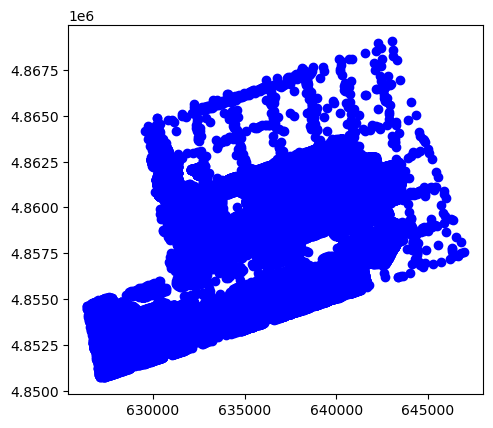

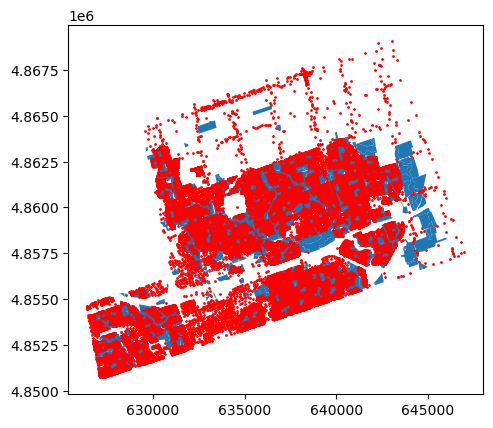

In [3]:
address_gdf.plot(color='blue')
ax1=address_gdf.plot(color='red', markersize=1)
parks_gdf.plot(ax=ax1)

Putting markham roads into a network

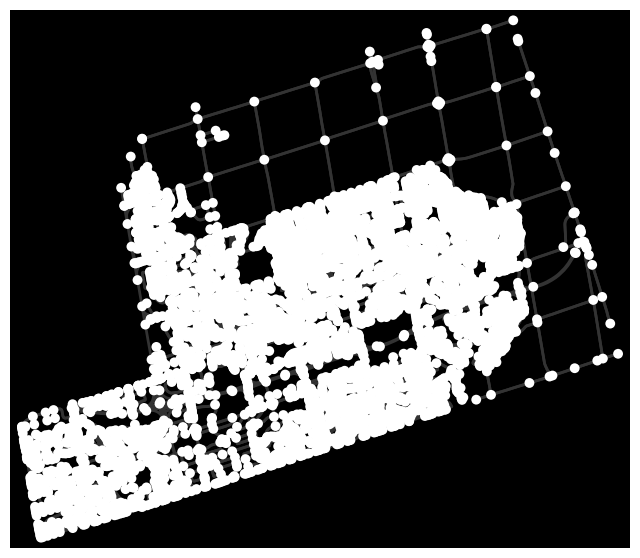

In [4]:
G = ox.graph.graph_from_place("Markham, ON, Canada", network_type="drive")

G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)
gdf_edges.head()

# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_size=50, edge_linewidth=2, edge_color="#333333"
)
gdf_nodes = gdf_nodes.to_crs('EPSG:26917')


Joining parks and houses to a nearby node in the network

In [6]:
new_gdf = address_gdf.sjoin_nearest(gdf_nodes)
new_gdf2 = parks_gdf.sjoin_nearest(gdf_nodes)

Actually finding the shortest path between the park and the house. Also prints the travel time in minutes

In [79]:
house_number = '208' #replace these for house number
street_name = 'FRED MCLAREN'

park_name = 'Monarch Park' #and park name
#did not account for writing the address wrong

result = new_gdf[(new_gdf['ADDRESS'] == house_number) & (new_gdf['STREET'] == street_name)]
park_result = new_gdf2[(new_gdf2['PARK_NAME'] == park_name)]

result = result.reset_index(drop=True)
park_result = park_result.reset_index(drop=True)

source_node = result['index_right'][0]  
target_node = park_result['index_right'][0]  

shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight="travel_time")
print("Shortest path between {} {} and {}:".format(house_number,street_name, park_name), shortest_path)
total_travel_time = nx.shortest_path_length(G, source=source_node, target=target_node, weight="travel_time")
print("\nTotal travel time along the shortest path:", total_travel_time, "mintues")

Shortest path between 208 FRED MCLAREN and Monarch Park: [701927108, 439190370, 439190417, 439190384, 439190363, 439190414, 439190468, 439189603, 1070280005, 439190444, 439190446, 439190458, 439189815, 439190467, 439190457, 439189765, 439190470, 7797664269, 7797664263, 7797664236, 7797664241, 7797664233, 437595079, 437595337, 437594245, 437603750, 437603740, 437603692, 3787777498, 3787777495, 3787777493, 442642730, 442601871, 442642726, 7797662122, 7797662125, 7797662118, 1553102619, 437941973, 437942014, 437941953, 437931770, 437932132, 437931403, 437931722, 437932976]

Total travel time along the shortest path: 352.90000000000003 mintues
